### Frequenncy_data_analysis

#### Import libraries

In [1]:
# Step 1: Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from sqlalchemy import text
from sqlalchemy import create_engine
import geopandas as gpd

#### Create the connection with the DB

In [2]:
# Step 1: Create the connection with the DB
engine = create_engine("postgresql://urbaninfo:@cirrus.ita.chalmers.se/se_tuptp")
conn = engine.connect()

In [3]:
# Step 2: Create a new schema when it is necessary
#schema = '''CREATE SCHEMA name_schema'''
#conn.execute(schema)

#### Import data

In [4]:
# Step 1: Import Data
# In this example, we are utilizing data from Västra Götaland, although these can be modified based on specific requirements.
# Links_model_0
links_pt_0_query = text('''SELECT * FROM pt_0_baseline.links_pt_0''')
links_pt_0 = gpd.read_postgis(links_pt_0_query, engine, geom_col='geometry')

# Calendar_dates GTFS
calendar_dates_gtfs_query = text('''SELECT * FROM p1_gtfs.regional_calendardates''')
calendar_dates_gtfs = pd.read_sql(calendar_dates_gtfs_query, engine)

#### Frequency Data Analysis

In [5]:
# Preprocess the calendar_dates data
# Step 1: Adjust the date format on the calendar_dates
calendar_dates_gtfs['date'] = pd.to_datetime(calendar_dates_gtfs['date'], format='%Y%m%d')

# Step 2: Create a column with the day of the week
calendar_dates_gtfs['day_week'] = calendar_dates_gtfs['date'].dt.day_name()

# Step 3: Create a column with the day type
day_type_dic = {
    'Monday': 'week_day',
    'Tuesday': 'week_day',
    'Wednesday': 'week_day',
    'Thursday': 'week_day',
    'Friday': 'week_day',
    'Saturday': 'weekend',
    'Sunday': 'weekend'
}
# Step 4: Create a day_type column based on the type of the day_week
calendar_dates_gtfs['day_type'] = calendar_dates_gtfs['day_week'].map(day_type_dic)

# Step 5: Create the week_start and the week_number columns based on the date
calendar_dates_gtfs['week_start'] = calendar_dates_gtfs['date'].dt.to_period('W').apply(lambda r: r.start_time)
calendar_dates_gtfs['week_number'] = calendar_dates_gtfs['week_start'].dt.isocalendar().week.astype(int)

# Step 6 (optional): Display the results
calendar_dates_gtfs.head()

,service_id,date,exception_type,day_week,day_type,week_start,week_number
0,1,2022-08-15,1,Monday,week_day,2022-08-15,33
1,1,2022-08-16,1,Tuesday,week_day,2022-08-15,33
2,1,2022-08-17,1,Wednesday,week_day,2022-08-15,33
3,1,2022-08-18,1,Thursday,week_day,2022-08-15,33
4,1,2022-08-19,1,Friday,week_day,2022-08-15,33


In [6]:
# Step 7: Merge the links of the baseline model with the modified calendar_dates droping duplicates trips by time period and date
links_calendar_merge = pd.merge (links_pt_0, calendar_dates_gtfs,
                                 on='service_id', how='inner').drop_duplicates(subset=['trip_id', 'time_period','date'])

# Step 8 (optional): Display the results
links_calendar_merge.head()

,source,target,route_short_name,mode,time_distance,time_period,route_id,service_id,trip_id,direction_id,...,stop_name_target,place_id_source,place_id_target,geometry,date,exception_type,day_week,day_type,week_start,week_number
0,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,307987564,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-07-31,1,Sunday,weekend,2022-07-25,30
1,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,307987564,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-06,1,Saturday,weekend,2022-08-01,31
2,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,307987564,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-07,1,Sunday,weekend,2022-08-01,31
3,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,307987564,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-13,1,Saturday,weekend,2022-08-08,32
4,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,Stenpiren,307987564,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-08-14,1,Sunday,weekend,2022-08-08,32


#### create the graphs to verify trip profiles

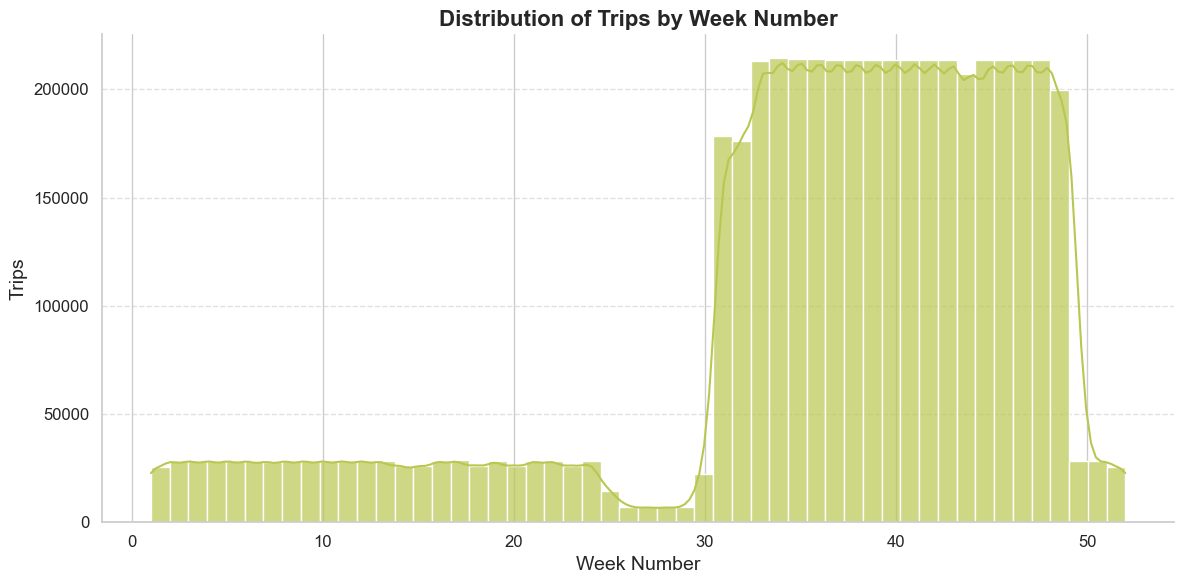

In [28]:
# Create the graphs to verify trip profiles
# Step 9: Verify the distribution of trips by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=links_calendar_merge, x='week_number', bins=52, color='#B9C750', alpha=0.7, ax=ax, kde=True)
ax.set_title('Distribution of Trips by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=14)
ax.set_ylabel('Trips', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 10: Display the results
plt.show()

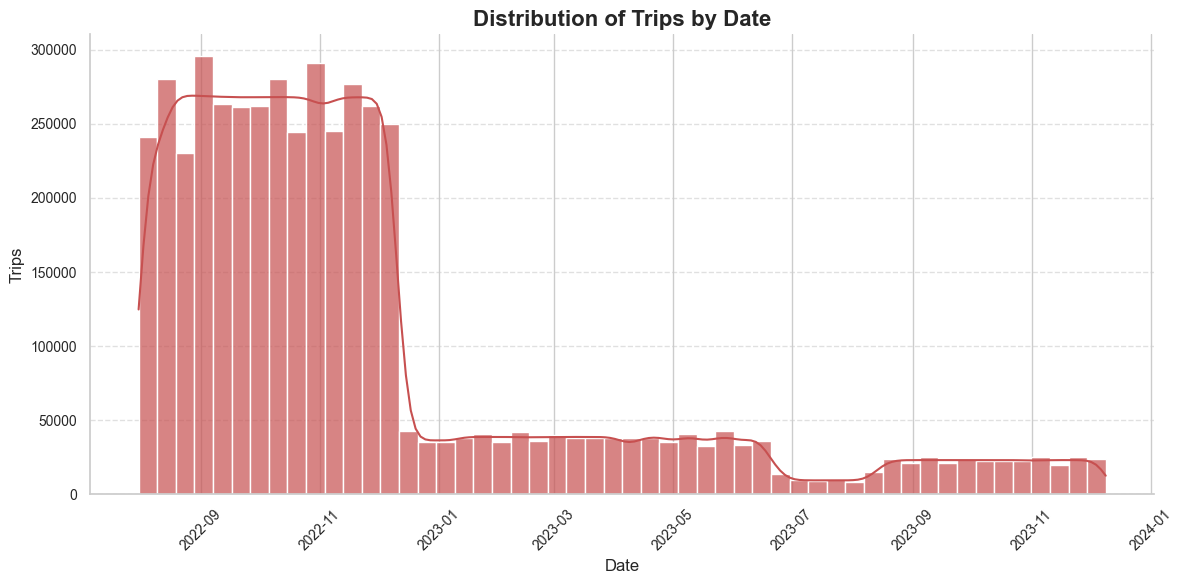

In [8]:
# Step 11: Verify the distribution of trips by date
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=links_calendar_merge, x='date', bins=52, color='#C75050', alpha=0.7, ax=ax, kde=True)
ax.set_title('Distribution of Trips by Date', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Step 12: Display the results
plt.show()

#### filter the DataFrame based on trip concentration

In [11]:
# Step 13: Filter the DataFrame based on trip concentration by date
links_calendar_filtered = links_calendar_merge[
    links_calendar_merge['date'].between('2022-09-01', '2022-12-10')
]

# Step 14: Create a week_count column based on route_id and service_id
links_calendar_filtered['week_count'] = links_calendar_filtered.groupby(['route_id', 'service_id'])['week_number'].transform('nunique')

# Step 15: Create a service_count column based on week_count
links_calendar_filtered['service_count'] = links_calendar_filtered.groupby(['week_count'])['service_id'].transform('nunique')

# Step 16: Display the results
links_calendar_filtered.head()

C:\Users\monaliza\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\monaliza\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,source,target,route_short_name,mode,time_distance,time_period,route_id,service_id,trip_id,direction_id,...,place_id_target,geometry,date,exception_type,day_week,day_type,week_start,week_number,week_count,service_count
9,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-03,1,Saturday,weekend,2022-08-29,35,15,244
10,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-04,1,Sunday,weekend,2022-08-29,35,15,244
11,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-10,1,Saturday,weekend,2022-09-05,36,15,244
12,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-11,1,Sunday,weekend,2022-09-05,36,15,244
13,9022014001760012,9022014006242004,50,bus_service,97.0,night_dawn,9011014505000000,5,141010001054458148,0,...,307987564,"LINESTRING (319300.968 6400118.943, 318713.953...",2022-09-17,1,Saturday,weekend,2022-09-12,37,15,244


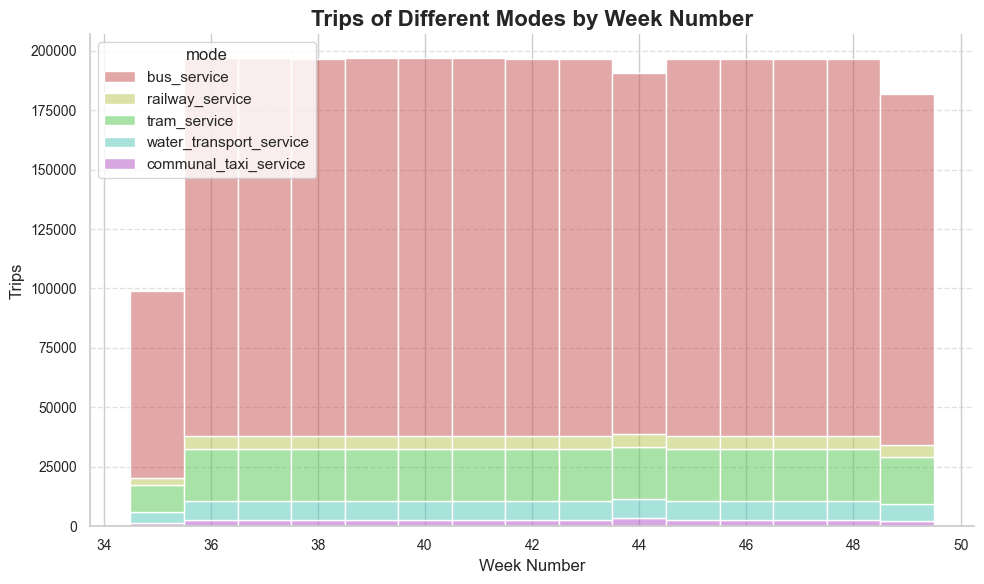

In [12]:
# Step 17a: Verify the distributions of trips of different modes by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=links_calendar_filtered, x='week_number', discrete=True, alpha=0.5, bins=52,
    hue='mode', element='bars', multiple='stack', palette= ['#C75050', '#B9C750', '#52C750', '#50C7B9', '#B350C7'], hue_order=['bus_service', 'railway_service', 'tram_service', 'water_transport_service', 'communal_taxi_service'], legend=True
)
ax.set_title('Trips of Different Modes by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 18a: Display the results
plt.show()

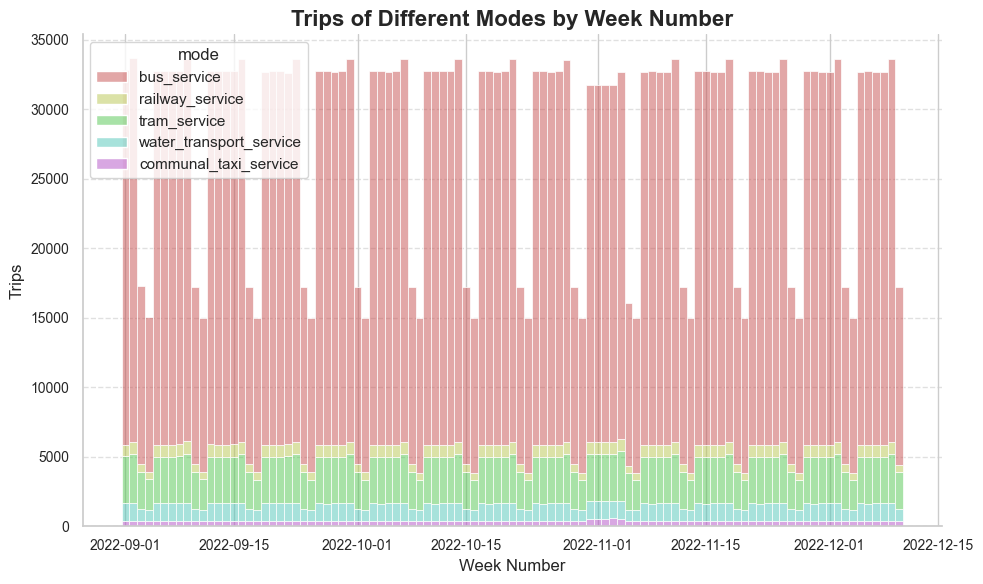

In [27]:
# Step 17b: Verify the distributions of trips of different modes by week number
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=links_calendar_filtered, x='date', discrete=True, alpha=0.5, bins=52,
    hue='mode', element='bars', multiple='stack', palette= ['#C75050', '#B9C750', '#52C750', '#50C7B9', '#B350C7'], hue_order=['bus_service', 'railway_service', 'tram_service', 'water_transport_service', 'communal_taxi_service'], legend=True
)
ax.set_title('Trips of Different Modes by Week Number', fontsize=16, fontweight='bold')
ax.set_xlabel('Week Number', fontsize=12)
ax.set_ylabel('Trips', fontsize=12)
ax.tick_params(axis='both', which='both', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 18b: Display the results
plt.show()

C:\Users\monaliza\AppData\Local\Temp\ipykernel_16636\2388710701.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


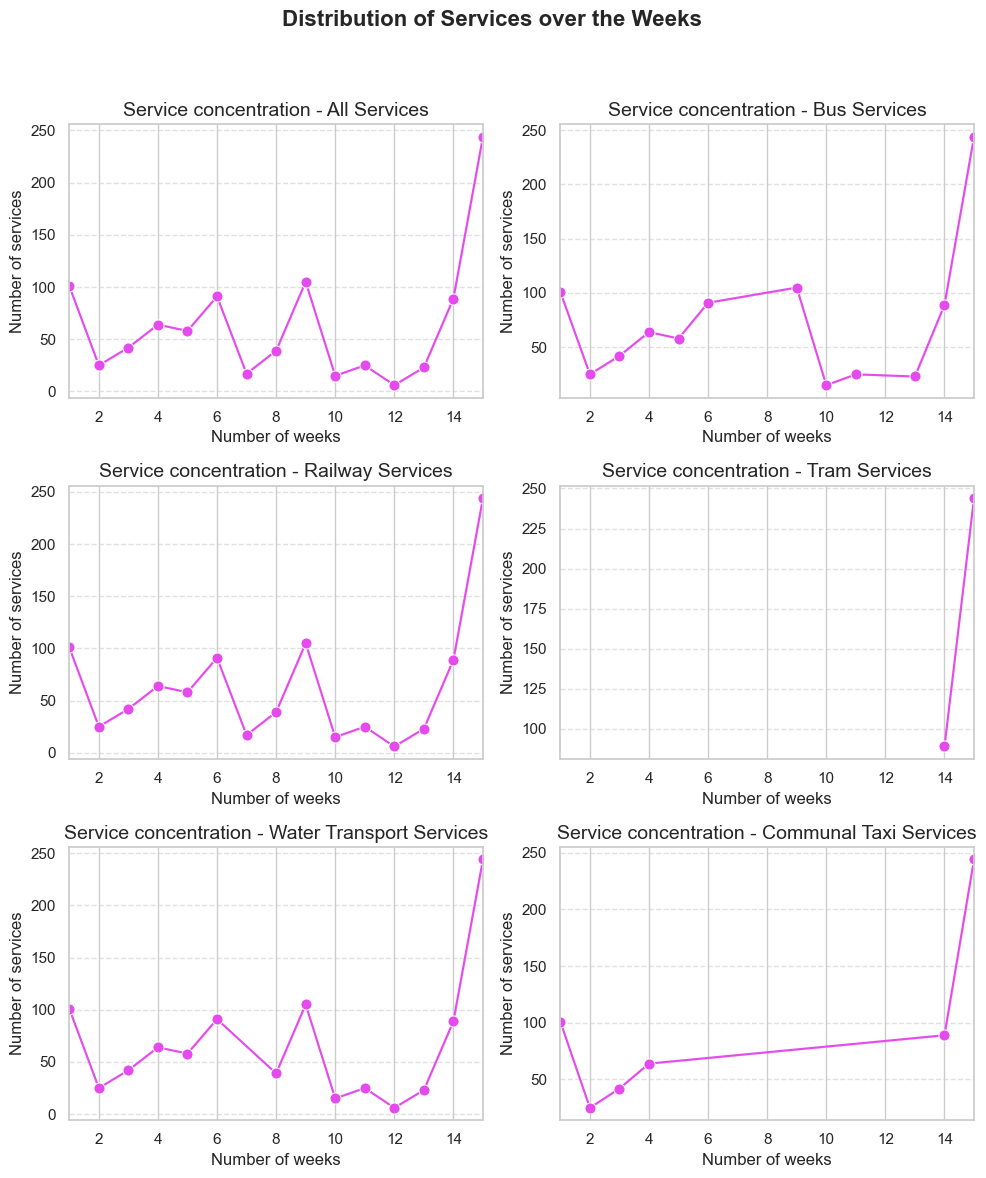

In [13]:
# Step 19: Verify the concentration of services over the week
# This step is essential to verify the regularity of operation for each service, and consequently, the regularity of operation for the entire public transport system.
fig, axes = plt.subplots(3, 2, figsize=(10, 12), constrained_layout=True)
service_modes = ['All Services', 'Bus Services', 'Railway Services', 'Tram Services', 'Water Transport Services', 'Communal Taxi Services']

x_min = links_calendar_filtered['week_count'].min()
x_max = links_calendar_filtered['week_count'].max()

for i, mode in enumerate(service_modes):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    if mode == 'All Services':
        data = links_calendar_filtered
    elif mode == 'Bus Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'bus_service']
    elif mode == 'Railway Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'railway_service']
    elif mode == 'Tram Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'tram_service']
    elif mode == 'Water Transport Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'water_transport_service']
    elif mode == 'Communal Taxi Services':
        data = links_calendar_filtered[links_calendar_filtered['mode'] == 'communal_taxi_service']

    g = sns.lineplot(data=data, x='week_count', y='service_count', color='#E54AED', marker='o', markersize=8, ax=ax)
    g.set_xlim(x_min, x_max)
    g.set_title(f'Service concentration - {mode}', fontsize=14)
    g.set_xlabel('Number of weeks', fontsize=12)
    g.set_ylabel('Number of services', fontsize=12)
    g.yaxis.grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Distribution of Services over the Weeks', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Step 20: Display the results
plt.show()

In [22]:
# Step 21: Verify whether the more regular services are complementary
# This step is essential for comprehending what must be filtered in order to gain a clearer understanding of the system's regular operations
#15 weeks
filtered_data_week_15 = links_calendar_filtered[links_calendar_filtered['week_count'] == 15]
unique_service_ids_15 = filtered_data_week_15['service_id'].unique().tolist()
links_calendar_filtered_routes_week_15 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_15)]
unique_route_ids_15 = links_calendar_filtered_routes_week_15['route_id'].unique().tolist()

#14 weeks
filtered_data_week_14 = links_calendar_filtered[links_calendar_filtered['week_count'] == 14]
unique_service_ids_14 = filtered_data_week_14['service_id'].unique().tolist()
links_calendar_filtered_routes_week_14 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_14)]
unique_route_ids_14 = links_calendar_filtered_routes_week_14['route_id'].unique().tolist()

#13 weeks
filtered_data_week_13 = links_calendar_filtered[links_calendar_filtered['week_count'] == 13]
unique_service_ids_13 = filtered_data_week_13['service_id'].unique().tolist()
links_calendar_filtered_routes_week_13 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_13)]
unique_route_ids_13 = links_calendar_filtered_routes_week_13['route_id'].unique().tolist()

#12 weeks
filtered_data_week_12 = links_calendar_filtered[links_calendar_filtered['week_count'] == 12]
unique_service_ids_12 = filtered_data_week_12['service_id'].unique().tolist()
links_calendar_filtered_routes_week_12 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_12)]
unique_route_ids_12 = links_calendar_filtered_routes_week_12['route_id'].unique().tolist()

#11 weeks
filtered_data_week_11 = links_calendar_filtered[links_calendar_filtered['week_count'] == 11]
unique_service_ids_11 = filtered_data_week_11['service_id'].unique().tolist()
links_calendar_filtered_routes_week_11 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_11)]
unique_route_ids_11 = links_calendar_filtered_routes_week_11['route_id'].unique().tolist()

#10 weeks
filtered_data_week_10 = links_calendar_filtered[links_calendar_filtered['week_count'] == 10]
unique_service_ids_10 = filtered_data_week_10['service_id'].unique().tolist()
links_calendar_filtered_routes_week_10 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_10)]
unique_route_ids_10 = links_calendar_filtered_routes_week_10['route_id'].unique().tolist()

#9 weeks
filtered_data_week_9 = links_calendar_filtered[links_calendar_filtered['week_count'] == 9]
unique_service_ids_9 = filtered_data_week_9['service_id'].unique().tolist()
links_calendar_filtered_routes_week_9 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_9)]
unique_route_ids_9 = links_calendar_filtered_routes_week_9['route_id'].unique().tolist()

#8 weeks
filtered_data_week_8 = links_calendar_filtered[links_calendar_filtered['week_count'] == 8]
unique_service_ids_8 = filtered_data_week_8['service_id'].unique().tolist()
links_calendar_filtered_routes_week_8 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_8)]
unique_route_ids_8 = links_calendar_filtered_routes_week_8['route_id'].unique().tolist()

#7 weeks
filtered_data_week_7 = links_calendar_filtered[links_calendar_filtered['week_count'] == 7]
unique_service_ids_7 = filtered_data_week_7['service_id'].unique().tolist()
links_calendar_filtered_routes_week_7 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_7)]
unique_route_ids_7 = links_calendar_filtered_routes_week_7['route_id'].unique().tolist()

#6 weeks
filtered_data_week_6 = links_calendar_filtered[links_calendar_filtered['week_count'] == 6]
unique_service_ids_6 = filtered_data_week_6['service_id'].unique().tolist()
links_calendar_filtered_routes_week_6 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_6)]
unique_route_ids_6 = links_calendar_filtered_routes_week_6['route_id'].unique().tolist()

#5 weeks
filtered_data_week_5 = links_calendar_filtered[links_calendar_filtered['week_count'] == 5]
unique_service_ids_5 = filtered_data_week_5['service_id'].unique().tolist()
links_calendar_filtered_routes_week_5 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_5)]
unique_route_ids_5 = links_calendar_filtered_routes_week_5['route_id'].unique().tolist()

#4 weeks
filtered_data_week_4 = links_calendar_filtered[links_calendar_filtered['week_count'] == 4]
unique_service_ids_4 = filtered_data_week_4['service_id'].unique().tolist()
links_calendar_filtered_routes_week_4 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_4)]
unique_route_ids_4 = links_calendar_filtered_routes_week_4['route_id'].unique().tolist()

#3 weeks
filtered_data_week_3 = links_calendar_filtered[links_calendar_filtered['week_count'] == 3]
unique_service_ids_3 = filtered_data_week_3['service_id'].unique().tolist()
links_calendar_filtered_routes_week_3 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_3)]
unique_route_ids_3 = links_calendar_filtered_routes_week_3['route_id'].unique().tolist()

#2 weeks
filtered_data_week_2 = links_calendar_filtered[links_calendar_filtered['week_count'] == 2]
unique_service_ids_2 = filtered_data_week_2['service_id'].unique().tolist()
links_calendar_filtered_routes_week_2 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_2)]
unique_route_ids_2 = links_calendar_filtered_routes_week_2['route_id'].unique().tolist()

#1 week
filtered_data_week_1 = links_calendar_filtered[links_calendar_filtered['week_count'] == 1]
unique_service_ids_1 = filtered_data_week_1['service_id'].unique().tolist()
links_calendar_filtered_routes_week_1 = links_calendar_filtered[links_calendar_filtered['service_id'].isin(unique_service_ids_1)]
unique_route_ids_1 = links_calendar_filtered_routes_week_1['route_id'].unique().tolist()

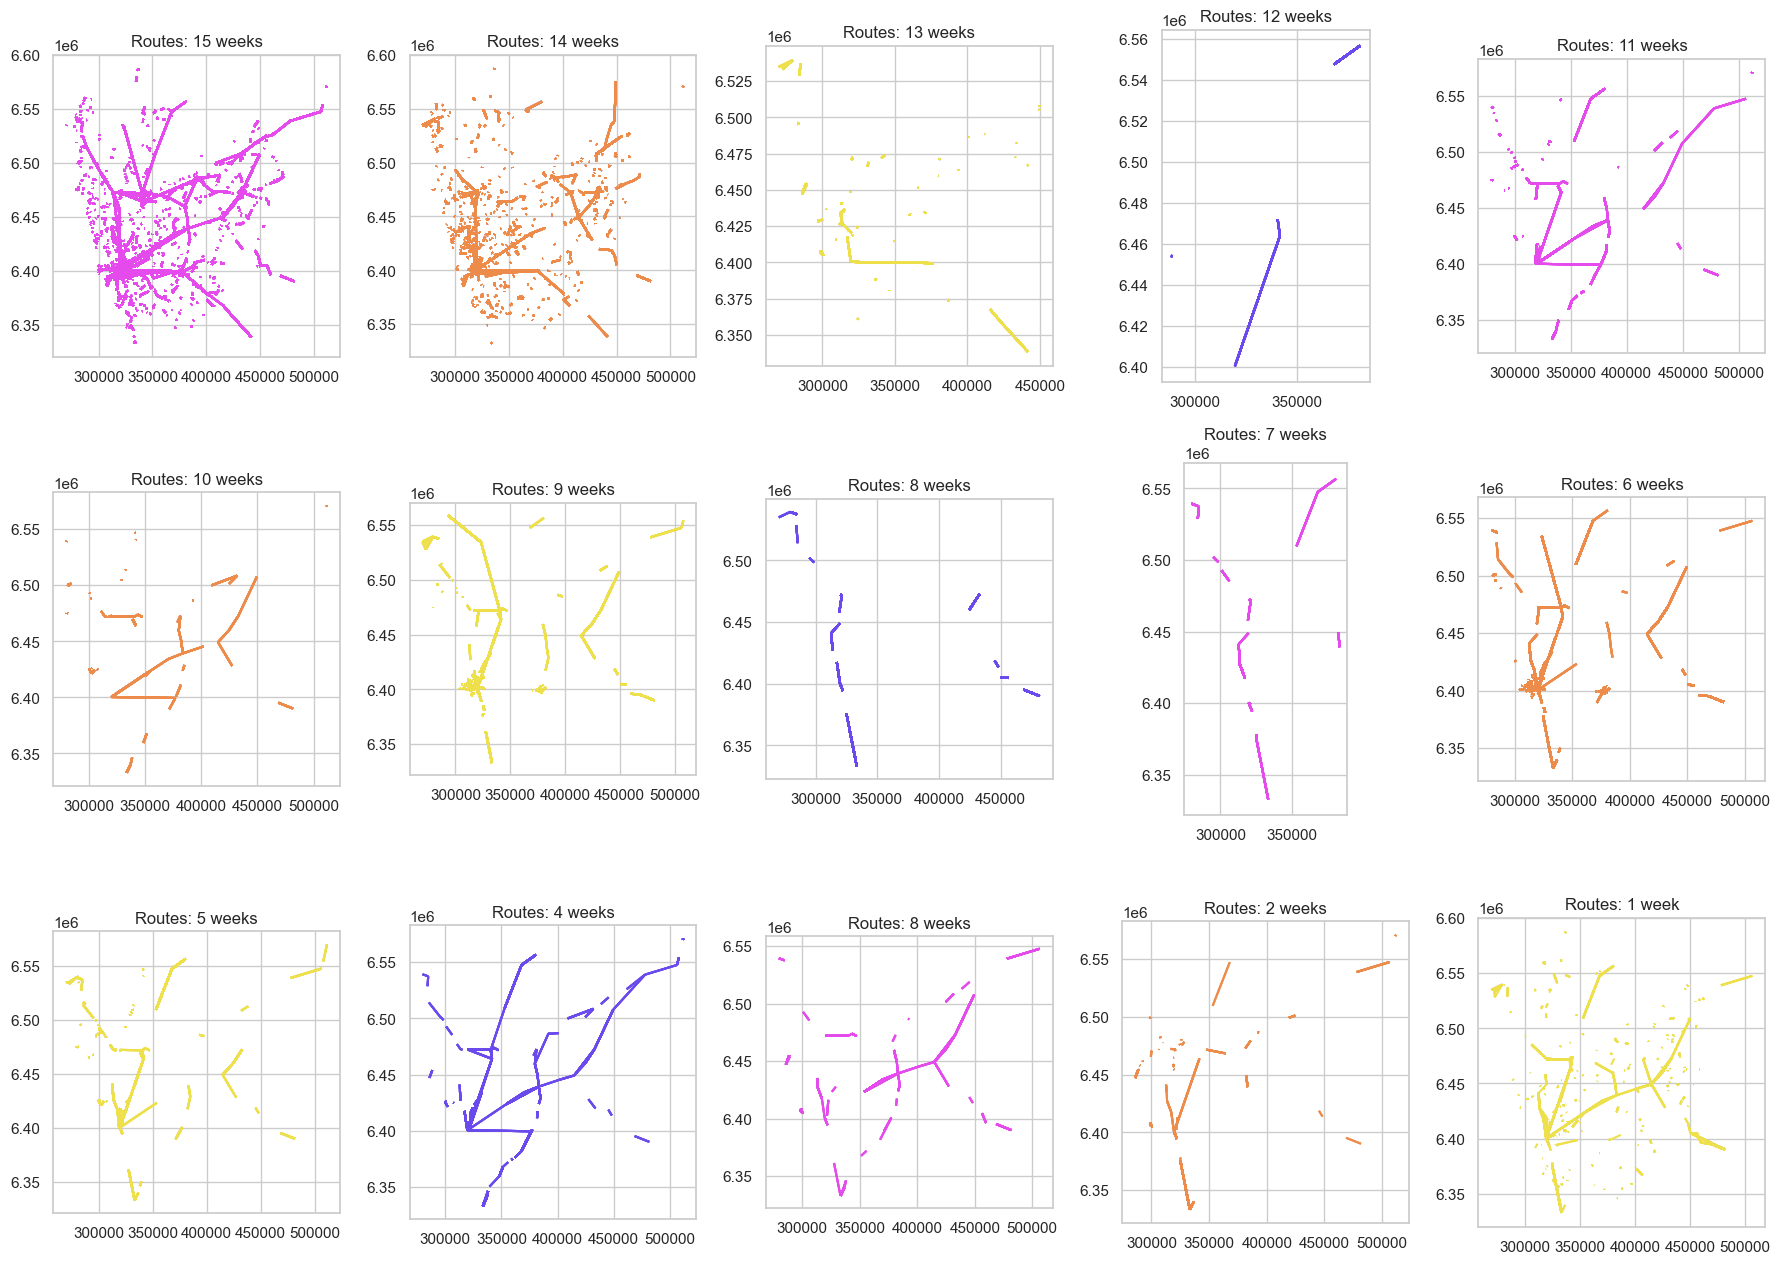

In [23]:
# Step 22: Plot the previous operation

fig, axes = plt.subplots(3,5, figsize=(18, 13))

links_calendar_filtered_routes_week_15.plot(ax=axes[0,0], color='#E54AED', edgecolor='k')
axes[0,0].set_title('Routes: 15 weeks')

links_calendar_filtered_routes_week_14.plot(ax=axes[0,1], color='#ED8B4A', edgecolor='k')
axes[0,1].set_title('Routes: 14 weeks')

links_calendar_filtered_routes_week_13.plot(ax=axes[0,2], color='#EDE04A', edgecolor='k')
axes[0,2].set_title('Routes: 13 weeks')

links_calendar_filtered_routes_week_12.plot(ax=axes[0,3], color='#6A4AED', edgecolor='k')
axes[0,3].set_title('Routes: 12 weeks')

links_calendar_filtered_routes_week_11.plot(ax=axes[0,4], color='#E54AED', edgecolor='k')
axes[0,4].set_title('Routes: 11 weeks')

links_calendar_filtered_routes_week_10.plot(ax=axes[1,0], color='#ED8B4A', edgecolor='k')
axes[1,0].set_title('Routes: 10 weeks')

links_calendar_filtered_routes_week_9.plot(ax=axes[1,1], color='#EDE04A', edgecolor='k')
axes[1,1].set_title('Routes: 9 weeks')

links_calendar_filtered_routes_week_8.plot(ax=axes[1,2], color='#6A4AED', edgecolor='k')
axes[1,2].set_title('Routes: 8 weeks')

links_calendar_filtered_routes_week_7.plot(ax=axes[1,3], color='#E54AED', edgecolor='k')
axes[1,3].set_title('Routes: 7 weeks')

links_calendar_filtered_routes_week_6.plot(ax=axes[1,4], color='#ED8B4A', edgecolor='k')
axes[1,4].set_title('Routes: 6 weeks')

links_calendar_filtered_routes_week_5.plot(ax=axes[2,0], color='#EDE04A', edgecolor='k')
axes[2,0].set_title('Routes: 5 weeks')

links_calendar_filtered_routes_week_4.plot(ax=axes[2,1], color='#6A4AED', edgecolor='k')
axes[2,1].set_title('Routes: 4 weeks')

links_calendar_filtered_routes_week_3.plot(ax=axes[2,2], color='#E54AED', edgecolor='k')
axes[2,2].set_title('Routes: 8 weeks')

links_calendar_filtered_routes_week_2.plot(ax=axes[2,3], color='#ED8B4A', edgecolor='k')
axes[2,3].set_title('Routes: 2 weeks')

links_calendar_filtered_routes_week_1.plot(ax=axes[2,4], color='#EDE04A', edgecolor='k')
axes[2,4].set_title('Routes: 1 week')

plt.tight_layout()

# Step 23: Display the results
plt.show()

C:\Users\monaliza\AppData\Local\Temp\ipykernel_16636\3959708140.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=weeks, y=counts, palette= ['#EDE04A', '#ED8B4A', '#E54AED','#6A4AED','#EDE04A','#ED8B4A', '#E54AED','#6A4AED','#EDE04A', '#ED8B4A', '#E54AED','#6A4AED','#EDE04A', '#ED8B4A', '#E54AED'])


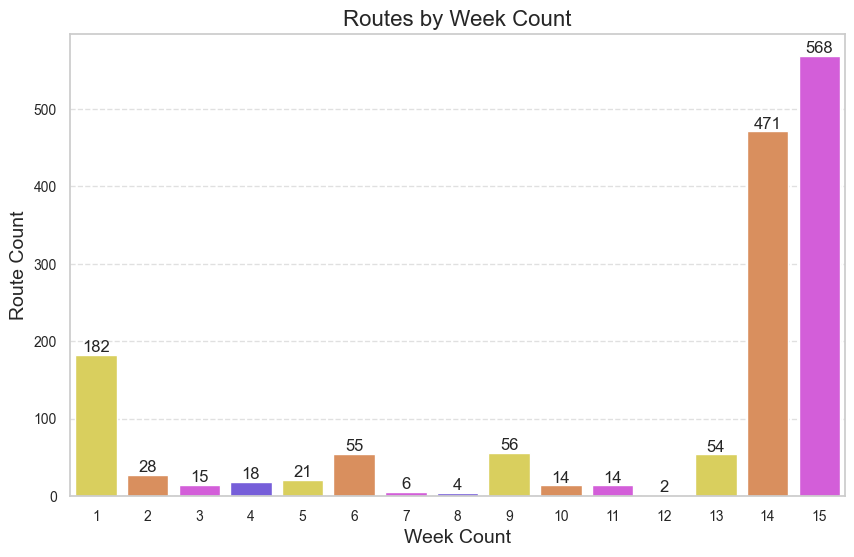

In [24]:
# Step 24: Visualize the number of routes operation
counts = [len(unique_route_ids_1),len(unique_route_ids_2),len(unique_route_ids_3),len(unique_route_ids_4),len(unique_route_ids_5),len(unique_route_ids_6), len(unique_route_ids_7), len(unique_route_ids_8), len(unique_route_ids_9), len(unique_route_ids_10), len(unique_route_ids_11), len(unique_route_ids_12), len(unique_route_ids_13), len(unique_route_ids_14), len(unique_route_ids_15)]
weeks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=weeks, y=counts, palette= ['#EDE04A', '#ED8B4A', '#E54AED','#6A4AED','#EDE04A','#ED8B4A', '#E54AED','#6A4AED','#EDE04A', '#ED8B4A', '#E54AED','#6A4AED','#EDE04A', '#ED8B4A', '#E54AED'])
plt.xlabel('Week Count', fontsize=14)
plt.ylabel('Route Count', fontsize=14)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='both', labelsize=10)
plt.title('Routes by Week Count', fontsize=16)
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

# Step 25: Display the results
plt.show()

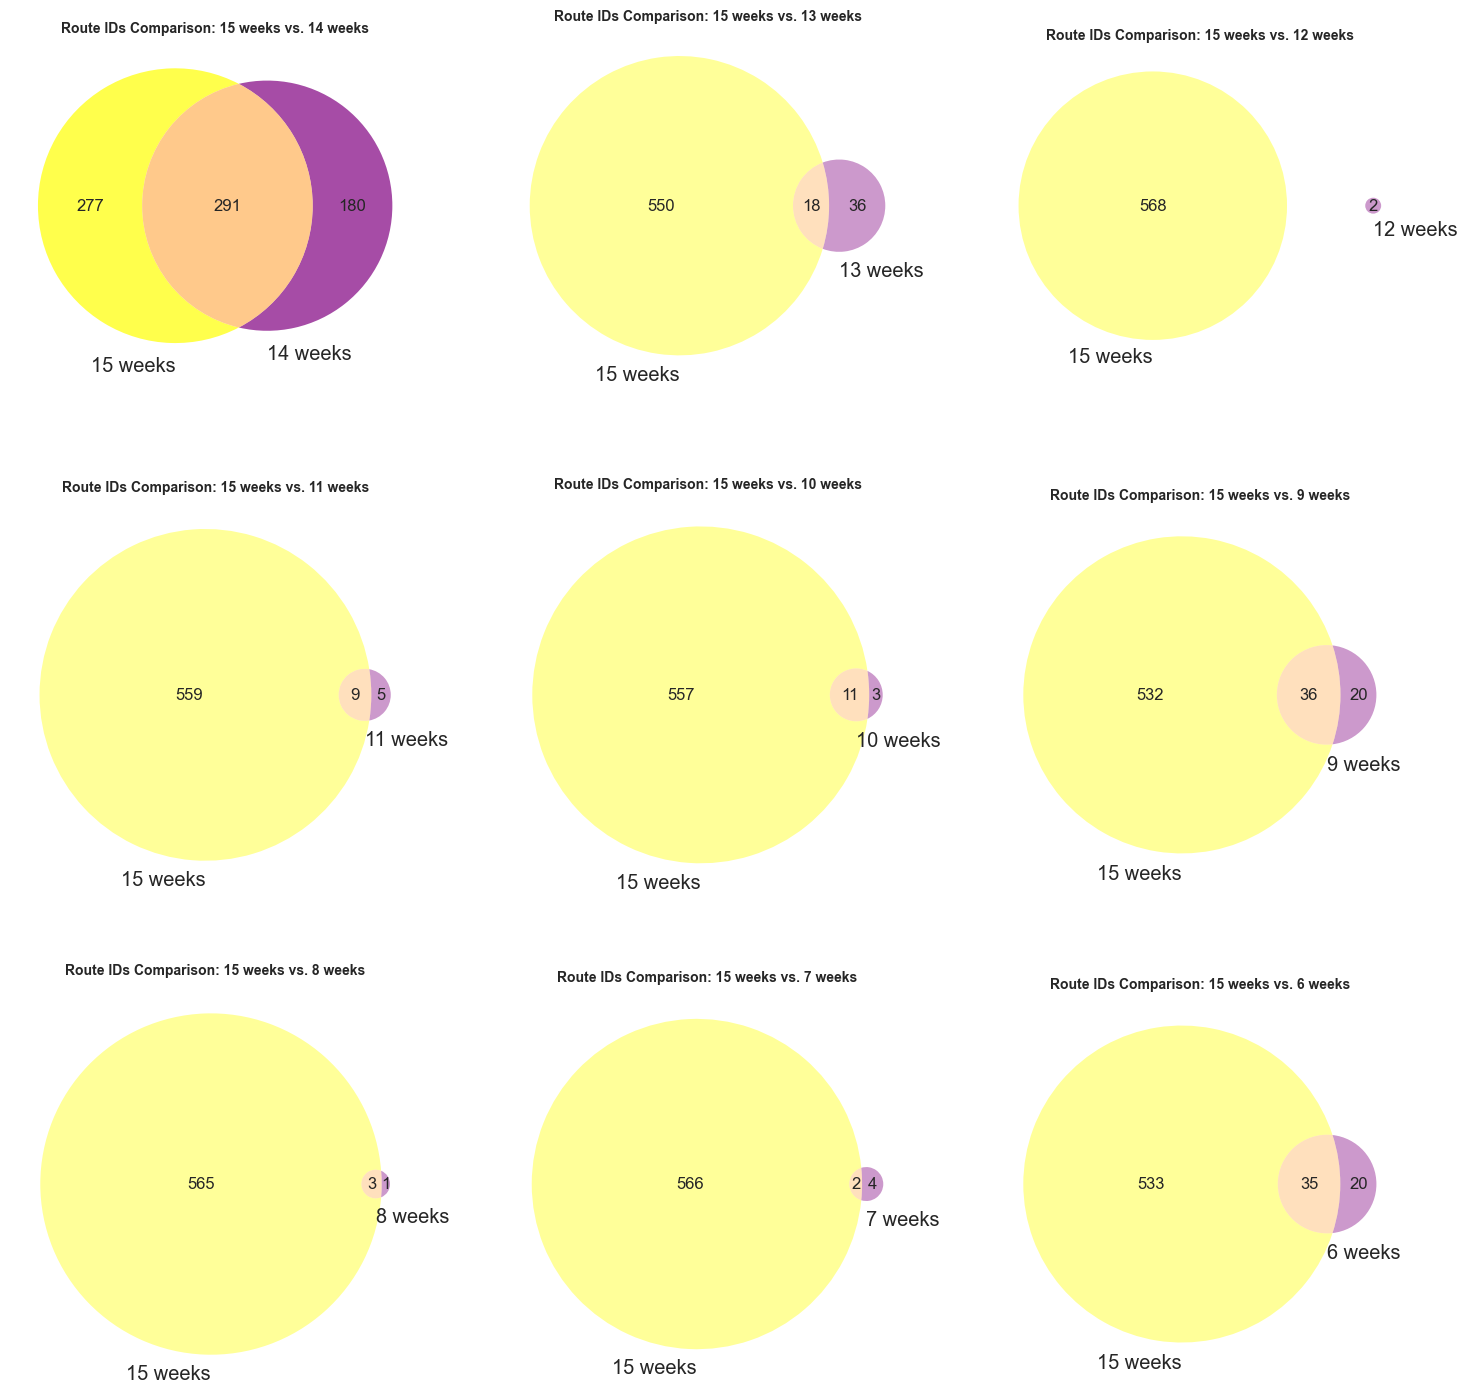

In [25]:
# Step 26: Visualize the overlapings of routes
fig, axs = plt.subplots(3,3, figsize=(18, 18))

axs[0,0].set_title('Route IDs Comparison: 15 weeks vs. 14 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_14)], set_labels=('15 weeks', '14 weeks'), set_colors=("yellow", "purple"), alpha=0.7, ax=axs[0,0])

axs[0,1].set_title('Route IDs Comparison: 15 weeks vs. 13 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_13)], set_labels=('15 weeks', '13 weeks'),  set_colors=("yellow", "purple"), ax=axs[0,1])

axs[0,2].set_title('Route IDs Comparison: 15 weeks vs. 12 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_12)], set_labels=('15 weeks', '12 weeks'), set_colors=("yellow", "purple"),  ax=axs[0,2])

axs[1,0].set_title('Route IDs Comparison: 15 weeks vs. 11 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_11)], set_labels=('15 weeks', '11 weeks'), set_colors=("yellow", "purple"),  ax=axs[1,0])

axs[1,1].set_title('Route IDs Comparison: 15 weeks vs. 10 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_10)], set_labels=('15 weeks', '10 weeks'), set_colors=("yellow", "purple"),  ax=axs[1,1])

axs[1,2].set_title('Route IDs Comparison: 15 weeks vs. 9 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_9)], set_labels=('15 weeks', '9 weeks'), set_colors=("yellow", "purple"),  ax=axs[1,2])

axs[2,0].set_title('Route IDs Comparison: 15 weeks vs. 8 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_8)], set_labels=('15 weeks', '8 weeks'), set_colors=("yellow", "purple"),  ax=axs[2,0])

axs[2,1].set_title('Route IDs Comparison: 15 weeks vs. 7 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_7)], set_labels=('15 weeks', '7 weeks'), set_colors=("yellow", "purple"),  ax=axs[2,1])

axs[2,2].set_title('Route IDs Comparison: 15 weeks vs. 6 weeks', fontsize=10, fontweight='bold')
venn2([set(unique_route_ids_15), set(unique_route_ids_6)], set_labels=('15 weeks', '6 weeks'), set_colors=("yellow", "purple"),  ax=axs[2,2])

# Step 27: Display the results
plt.show()

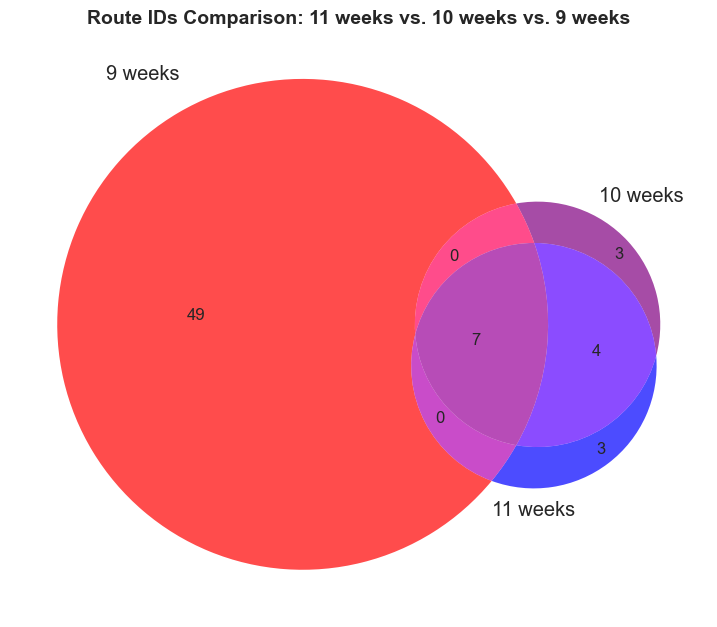

In [26]:
# Step 28: Visualize the overlapings of routes
fig, ax = plt.subplots(figsize=(9, 9))

ax.set_title('Route IDs Comparison: 11 weeks vs. 10 weeks vs. 9 weeks', fontsize=14, fontweight='bold')
venn3([set(unique_route_ids_9), set(unique_route_ids_10), set(unique_route_ids_11)],
      set_labels=('9 weeks', '10 weeks', '11 weeks'),
      set_colors=('red', 'purple', 'blue'),
      alpha=0.7,
      ax=ax)

plt.show()